## README
This notebook contains raw analysis regarding the monthly insight of October about the shortcut impact in malmo

In [2]:
import json
import pandas as pd
#from google.cloud import bigquery
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import ast  # To safely parse stringified lists
import geopandas as gpd
from shapely.geometry import Polygon,Point, LineString
from pyproj import CRS, Transformer
import numpy as np
from google.cloud import bigquery


import folium
from folium.plugins import HeatMap


In [3]:
merged_df_hfb = pd.read_csv("merged_hfb_may_19_Oct.csv")

merded_df_all = pd.read_csv("merged_overall_may_19_Oct.csv")

In [19]:
df_all_ariadne = merded_df_all[['local_date','visitors_ariadne']]

df_all_ariadne = df_all_ariadne.rename(columns={"local_date":"date", "visitors_ariadne": "store_total" })
df_all_ariadne["date"] = pd.to_datetime(df_all_ariadne["date"], errors="coerce")


## OVERALL PLOT OF HFB VISITOR TRENDS

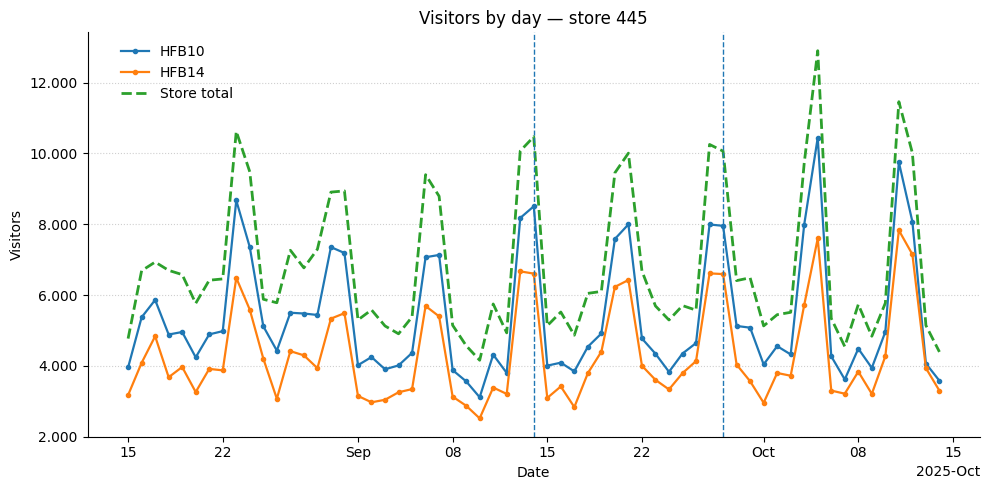

In [14]:


# Inputs
target_names = ["HFB14","HFB10"]
target_store = "445"

# Prep
df = merged_df_hfb.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["store_str"] = df["store"].astype(str)

# Merge daily store_total (already daily totals)
# df_all_ariadne must have ['date','store_total']
df = df.merge(df_all_ariadne, on="date", how="left")
df = df[(df["store_str"] == target_store) & (df["date"] >= "2025-08-15")& (df["date"] < "2025-10-15")]

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each HFB (daily sums in case multiple rows per day/HFB)
for name, g in df[df["name"].isin(target_names)].groupby("name"):
    s = g.set_index("date")["visitors"].resample("D").sum()
    ax.plot(s.index, s.values, marker="o", linewidth=1.6, markersize=3, label=name)

# Plot store_total on the SAME y-axis (no sum; one value per day)
store_daily = (df[["date","store_total"]]
               .drop_duplicates("date")
               .set_index("date")
               .asfreq("D")["store_total"])
ax.plot(store_daily.index, store_daily.values, linestyle="--", linewidth=2.0, label="Store total")

# Presentation
ax.set_title(f"Visitors by day — store {target_store}")
ax.set_xlabel("Date"); ax.set_ylabel("Visitors")

locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _ : f"{int(x):,}".replace(",", ".")))

ax.grid(axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

# Vertical markers (optional)
ax.axvline(pd.to_datetime("2025-09-28"), linestyle="--", linewidth=1)
ax.axvline(pd.to_datetime("2025-09-14"), linestyle="--", linewidth=1)

ax.legend(title="", frameon=False, bbox_to_anchor=(0.1,0.9), loc="center")
plt.tight_layout(); plt.show()


## OVERALL TREND LIFT BY HFB IN the pre - post periods

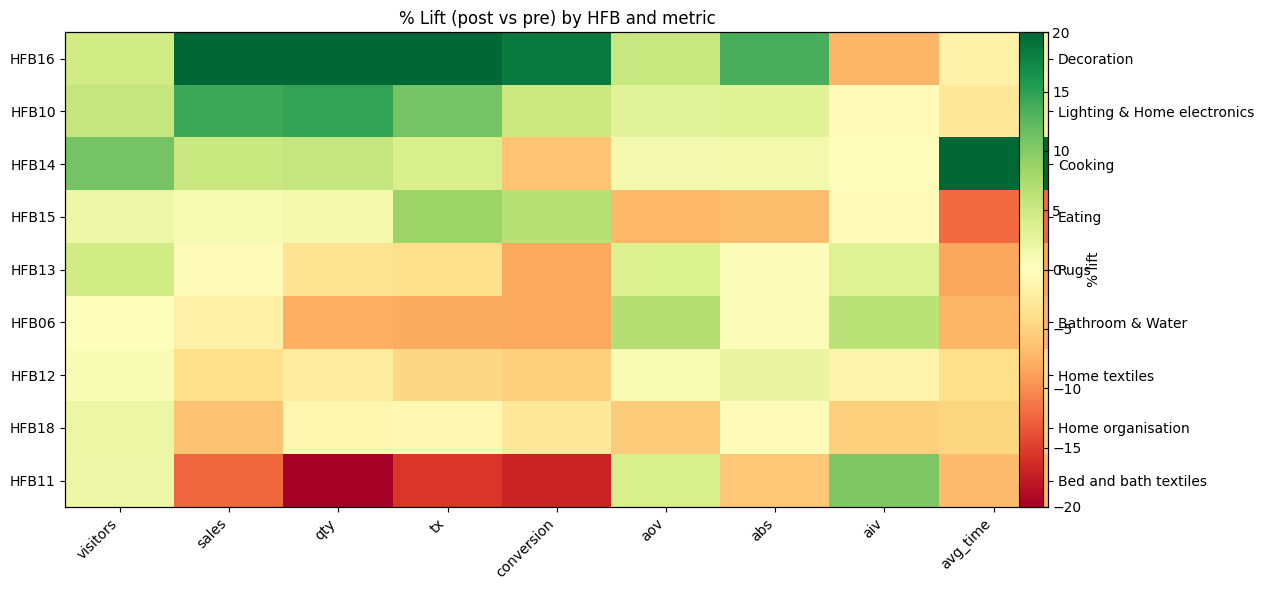

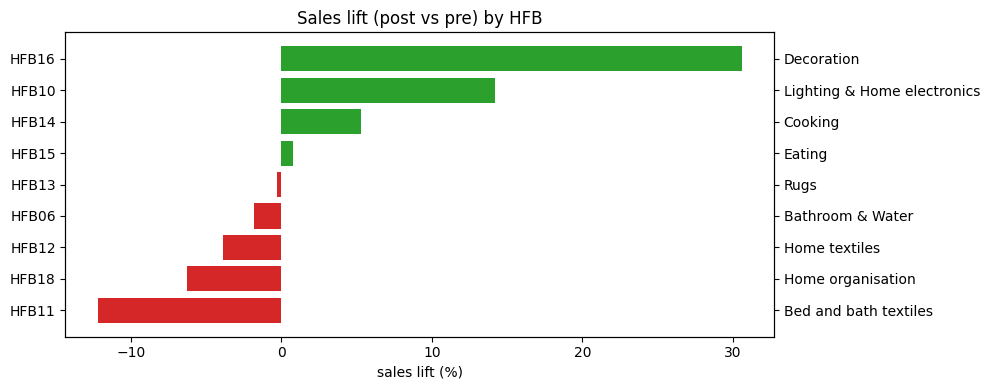

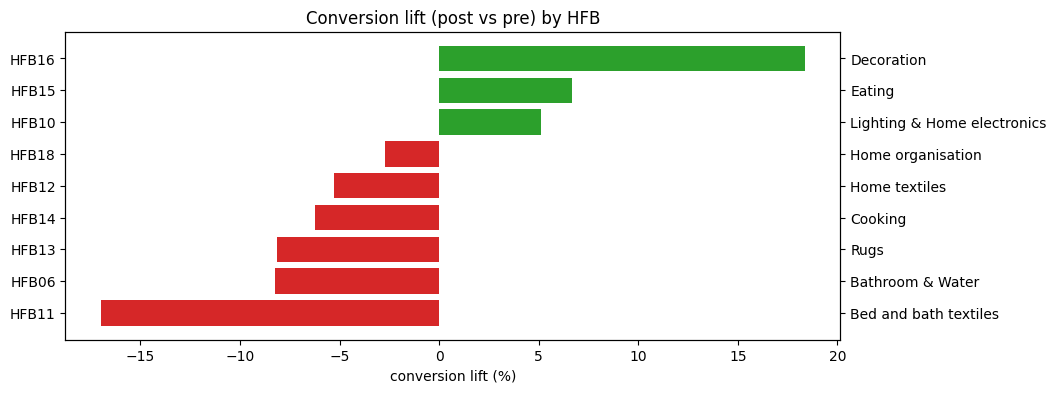

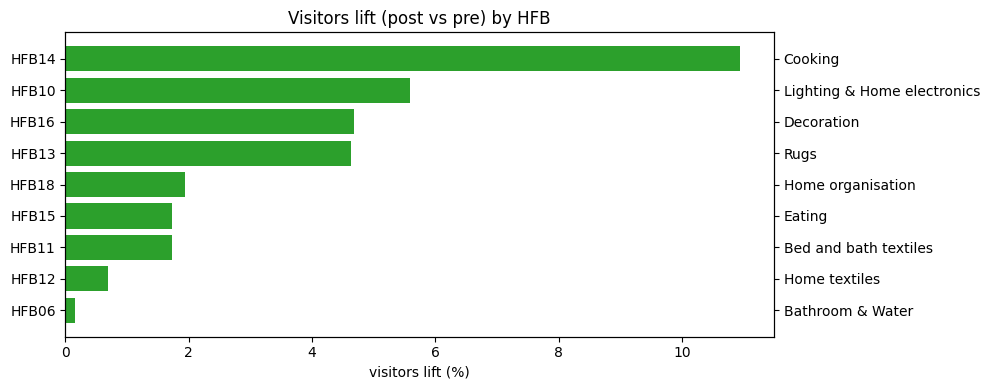

    name  visitors_pre  sales_pre  tx_pre  avg_time_pre   qty_pre  \
0  HFB06        119315  251340.25   10166          2.61   17863.0   
1  HFB10        117956  389502.12   13454          3.55   39986.0   
2  HFB11        115865  510436.36   17459          2.48   52625.0   
3  HFB12        111414  303099.27   10088          2.67   38309.0   
4  HFB13        116362  207917.05    5588          1.94    7820.0   
5  HFB14         91570  331375.29   25640          2.30   88672.0   
6  HFB15        102592  225229.85   17101          2.14   79710.0   
7  HFB16         80612  390889.31   23291          3.94   79968.0   
8  HFB18        117939  335066.47   32539          3.63  111571.0   

   visitors_post  sales_post  tx_post  avg_time_post  qty_post  \
0         119496   246711.17     9343           2.42   16486.0   
1         124547   444838.24    14936           3.45   45841.0   
2         117859   448050.67    14741           2.31   41834.0   
3         112186   291247.29     9623        

In [37]:


# ===== Inputs =====
DATE1, DATE2 = pd.to_datetime("2025-08-24"), pd.to_datetime("2025-09-14")  # PRE window
DATE3, DATE4 = pd.to_datetime("2025-09-28"), pd.to_datetime("2025-10-19")  # POST window
METRICS = ["visitors","sales","qty","tx","conversion","aov","abs","aiv","avg_time"]
LABEL_COL = "name"     # HFB identifier (e.g., "HFB10")

# ===== Prep =====
df = merged_df_hfb.loc[merged_df_hfb.name.isin(["HFB14", "HFB15",
                                               "HFB12", "HFB11",
                                               "HFB18", "HFB10",
                                               "HFB13", "HFB16","HFB06"])].copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")

pre  = df[df["date"].between(DATE1, DATE2)].copy()
post = df[df["date"].between(DATE3, DATE4)].copy()

def agg_block(d):
    g = d.groupby(LABEL_COL)
    out = pd.DataFrame({
        "days":      g["date"].nunique(),
        "visitors":  g["visitors"].sum(),
        "sales":     g["created_sales_net_amount_euro"].sum(),
        "qty":       g["created_net_quantity"].sum(),
        "tx":        g["unique_transaction_identifier"].sum(),
        "avg_time":        g["avg_time"].mean(),

    }).reset_index()
    # derived
    out["conversion"]    = out["tx"]    / out["visitors"].replace(0, np.nan)
    out["aov"]           = out["sales"] / out["tx"].replace(0, np.nan)
    out["abs"]  = out["qty"]   / out["tx"].replace(0, np.nan)
    out["aiv"]           = out["sales"] / out["qty"].replace(0, np.nan)
    return out

pre_agg  = agg_block(pre).rename(columns={m: f"{m}_pre"  for m in ["days"]+METRICS})
post_agg = agg_block(post).rename(columns={m: f"{m}_post" for m in ["days"]+METRICS})

# Join pre/post on HFB
res = pre_agg.merge(post_agg, on=LABEL_COL, how="outer")

# Compute deltas & % lifts
for m in METRICS:
    res[f"{m}_delta"] = res[f"{m}_post"] - res[f"{m}_pre"]
    res[f"{m}_lift_pct"] = np.where(
        (res[f"{m}_pre"].notna()) & (res[f"{m}_pre"] != 0),
        (res[f"{m}_post"] - res[f"{m}_pre"]) / res[f"{m}_pre"] * 100,
        np.nan
    )

# Map HFB code -> full name (e.g., "HFB10" -> "Cooking")
name_to_full = (
    df[["name", "hfb_name"]]
      .dropna()
      .drop_duplicates()
      .set_index("name")["hfb_name"]
)

# ===== Heatmap of % lifts across metrics (left: code, right: full name) =====
heat_cols = [f"{m}_lift_pct" for m in METRICS]
heat = res[[LABEL_COL] + heat_cols].set_index(LABEL_COL)
# order by sales lift (optional)
if "sales_lift_pct" in heat.columns:
    heat = heat.sort_values("sales_lift_pct", ascending=False)

fig, ax = plt.subplots(figsize=(12, max(6, 0.35*len(heat))))
im = ax.imshow(heat.values, aspect="auto", cmap="RdYlGn", vmin=-20, vmax=20)

# Left y-axis: codes
ax.set_yticks(range(len(heat)))
ax.set_yticklabels(heat.index)

# Right y-axis: names
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(len(heat)))
ax2.set_yticklabels(name_to_full.reindex(heat.index).fillna("").tolist())
ax2.tick_params(axis="y")

# X labels etc.
ax.set_xticks(range(len(METRICS)))
ax.set_xticklabels(METRICS, rotation=45, ha="right")
ax.set_title("% Lift (post vs pre) by HFB and metric")
cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.05)
cbar.set_label("% lift")
plt.tight_layout()
plt.show()

# ===== Bar chart for sales % lift (dual y-axis labels) =====
metric = "sales"
bar = res[[LABEL_COL, f"{metric}_lift_pct"]].dropna().sort_values(f"{metric}_lift_pct", ascending=False)
fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(bar))))
colors = np.where(bar[f"{metric}_lift_pct"] >= 0, "#2ca02c", "#d62728")
ax.barh(bar[LABEL_COL], bar[f"{metric}_lift_pct"], color=colors)
ax.invert_yaxis()
ax.set_xlabel(f"{metric} lift (%)")
ax.set_title(f"{metric.capitalize()} lift (post vs pre) by HFB")

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(name_to_full.reindex(bar[LABEL_COL]).fillna("").tolist())
ax2.tick_params(axis="y")

plt.tight_layout(); plt.show()

# ===== Bar chart for conversion % lift (dual y-axis labels) =====
metric = "conversion"
bar = res[[LABEL_COL, f"{metric}_lift_pct"]].dropna().sort_values(f"{metric}_lift_pct", ascending=False)
fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(bar))))
colors = np.where(bar[f"{metric}_lift_pct"] >= 0, "#2ca02c", "#d62728")
ax.barh(bar[LABEL_COL], bar[f"{metric}_lift_pct"], color=colors)
ax.invert_yaxis()
ax.set_xlabel(f"{metric} lift (%)")
ax.set_title(f"{metric.capitalize()} lift (post vs pre) by HFB")

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(name_to_full.reindex(bar[LABEL_COL]).fillna("").tolist())
ax2.tick_params(axis="y")


# ===== Bar chart for conversion % lift (dual y-axis labels) =====
metric = "visitors"
bar = res[[LABEL_COL, f"{metric}_lift_pct"]].dropna().sort_values(f"{metric}_lift_pct", ascending=False)
fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(bar))))
colors = np.where(bar[f"{metric}_lift_pct"] >= 0, "#2ca02c", "#d62728")
ax.barh(bar[LABEL_COL], bar[f"{metric}_lift_pct"], color=colors)
ax.invert_yaxis()
ax.set_xlabel(f"{metric} lift (%)")
ax.set_title(f"{metric.capitalize()} lift (post vs pre) by HFB")

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(name_to_full.reindex(bar[LABEL_COL]).fillna("").tolist())
ax2.tick_params(axis="y")

plt.tight_layout(); plt.show()

# ===== Optional: compact table preview =====
show_cols = [LABEL_COL] + [f"{m}_pre" for m in ["visitors","sales","tx","avg_time","qty"]] + \
            [f"{m}_post" for m in ["visitors","sales","tx","avg_time","qty"]] + \
            [f"{m}_lift_pct" for m in ["visitors","sales","tx","conversion","avg_time","qty"]]
print(res[show_cols].round(2))


In [16]:

# --- choose which "avg time" column you have in `res` ---
AVG_COL = "avg_time_min" if "avg_time_min_pre" in res.columns else (
          "avg_time"     if "avg_time_pre"     in res.columns else None)

# Core metrics to display
base_metrics  = ["visitors","sales","tx"]
if AVG_COL: base_metrics.append(AVG_COL)

# Metrics that also have a lift column
lift_metrics  = ["visitors","sales","tx","conversion"]
if AVG_COL: lift_metrics.append(AVG_COL)

# Build column order: LABEL_COL first, then for each metric → pre, post, lift%
ordered = [LABEL_COL]
for m in base_metrics:
    ordered += [f"{m}_pre", f"{m}_post"]
for m in lift_metrics:
    if f"{m}_lift_pct" in res.columns:
        ordered.append(f"{m}_lift_pct")

# Subset (ignore missing columns safely)
ordered = [c for c in ordered if c in res.columns]
tbl = res[ordered].copy()

# --- Pretty formatting with Styler (Jupyter) ---
fmt = {
    # big totals
    f"{m}_pre": "{:,.0f}"  for m in ["visitors","sales","tx"] if f"{m}_pre"  in tbl.columns
} | {
    f"{m}_post": "{:,.0f}" for m in ["visitors","sales","tx"] if f"{m}_post" in tbl.columns
}

# rates/averages
for col in [AVG_COL, "conversion", "aov", "items_per_tx", "aiv"]:
    if col:
        if f"{col}_pre"  in tbl.columns:  fmt[f"{col}_pre"]  = "{:.3f}"
        if f"{col}_post" in tbl.columns:  fmt[f"{col}_post"] = "{:.3f}"

# percent lifts
for m in lift_metrics:
    c = f"{m}_lift_pct"
    if c in tbl.columns:
        fmt[c] = "{:+.2f}%"

styled = (tbl.style
    .format(fmt, na_rep="–")
    .hide(axis="index")
    .set_table_styles([
        {"selector":"th", "props":"text-align:left;"},
        {"selector":"td", "props":"text-align:right; padding:4px 8px;"},
    ])
    .set_properties(subset=[LABEL_COL], **{"text-align":"left","font-weight":"bold"})
    .background_gradient(
        subset=[c for c in tbl.columns if c.endswith("_lift_pct")],
        cmap="RdYlGn", vmin=-20, vmax=20
    )
)

display(styled)


name,visitors_pre,visitors_post,sales_pre,sales_post,tx_pre,tx_post,avg_time_pre,avg_time_post,visitors_lift_pct,sales_lift_pct,tx_lift_pct,conversion_lift_pct,avg_time_lift_pct
HFB01,"96,984","98,082","482,538","458,707","2,410","2,207",6.503,6.455,+1.13%,-4.94%,-8.42%,-9.45%,-0.74%
HFB02,"94,412","92,982","398,780","431,042","4,699","4,659",5.021,4.901,-1.51%,+8.09%,-0.85%,+0.67%,-2.38%
HFB03,"75,792","76,251","253,254","240,873","2,581","2,308",2.321,2.321,+0.61%,-4.89%,-10.58%,-11.12%,-0.02%
HFB04,"80,969","79,205","683,196","678,034","6,630","6,260",5.039,5.190,-2.18%,-0.76%,-5.58%,-3.48%,+2.99%
HFB05,"76,664","76,060","615,614","486,088","3,116","2,607",4.412,4.354,-0.79%,-21.04%,-16.34%,-15.67%,-1.32%
HFB06,"119,315","119,496","251,340","246,711","10,166","9,343",2.610,2.420,+0.15%,-1.84%,-8.10%,-8.23%,-7.26%
HFB07,"78,428","78,457","646,435","848,105","6,434","6,804",6.975,7.414,+0.04%,+31.20%,+5.75%,+5.71%,+6.30%
HFB08,"76,378","75,833","172,972","172,300","1,428","1,329",2.590,2.577,-0.71%,-0.39%,-6.93%,-6.26%,-0.49%
HFB09,"82,600","80,338","195,862","211,448","9,051","9,626",6.833,6.870,-2.74%,+7.96%,+6.35%,+9.35%,+0.55%
HFB10,"117,956","124,547","389,502","444,838","13,454","14,936",3.550,3.455,+5.59%,+14.21%,+11.02%,+5.14%,-2.69%


In [17]:

# --- Inputs ---
DATE1, DATE2 = pd.to_datetime("2025-08-24"), pd.to_datetime("2025-09-14")  # PRE
DATE3, DATE4 = pd.to_datetime("2025-09-28"), pd.to_datetime("2025-10-19")  # POST
STORE_CSV = "merged_overall_may_19_Oct.csv"  # daily store totals

merged_df_hfb = pd.read_csv("merged_hfb_may_19_Oct.csv")
# --- HFB-level data (per-area) ---
df = merged_df_hfb.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")

pre  = df[df["date"].between(DATE1, DATE2)].copy()
post = df[df["date"].between(DATE3, DATE4)].copy()

# --- Store totals per day (from CSV) ---
store = pd.read_csv(STORE_CSV)
store["date"] = pd.to_datetime(store["date"], errors="coerce")

# keep only needed cols and coerce numerics
for c in ["visitors_ariadne","created_sales_net_amount_euro",
          "unique_transaction_identifier","created_net_quantity"]:
    store[c] = pd.to_numeric(store[c], errors="coerce")

# build daily store totals (one row per day)
def day_store_totals_from_csv(daily_df: pd.DataFrame) -> pd.DataFrame:
    return (daily_df.groupby("date", as_index=False)
            .agg(store_visitors=("visitors_ariadne", "max"),   # take the daily value
                 store_sales=("created_sales_net_amount_euro", "sum"),
                 store_tx=("unique_transaction_identifier", "sum"),
                 store_qty=("created_net_quantity", "sum")))

pre_tot  = day_store_totals_from_csv(store[store["date"].between(DATE1, DATE2)])
post_tot = day_store_totals_from_csv(store[store["date"].between(DATE3, DATE4)])

# --- Aggregate HFBs and compute shares vs *store CSV* totals ---
def agg_hfb(d: pd.DataFrame, store_tot: pd.DataFrame) -> pd.DataFrame:
    # join per-day store totals to HFB rows
    d2 = d.merge(store_tot, on="date", how="left")

    g = d2.groupby("name", as_index=False).agg(
        visitors=("visitors","sum"),
        sales=("created_sales_net_amount_euro","sum"),
        tx=("unique_transaction_identifier","sum"),
        qty=("created_net_quantity","sum"),
        # window store totals (sum of per-day totals)
        store_V=("store_visitors","sum"),
        store_S=("store_sales","sum"),
        store_T=("store_tx","sum"),
        store_Q=("store_qty","sum"),
    )

    # shares & per-visitor metrics
    g["visitor_share"] = g["visitors"] / g["store_V"].replace(0, np.nan)
    g["sales_share"]   = g["sales"]    / g["store_S"].replace(0, np.nan)

    g["conversion"]        = g["tx"] / g["visitors"].replace(0, np.nan)
    g["conversion_store"]  = g["store_T"] / g["store_V"].replace(0, np.nan)

    g["aov"]       = g["sales"] / g["tx"].replace(0, np.nan)
    g["aov_store"] = g["store_S"] / g["store_T"].replace(0, np.nan)

    g["aiv"]       = g["sales"] / g["qty"].replace(0, np.nan)
    g["aiv_store"] = g["store_S"] / g["store_Q"].replace(0, np.nan)

    g["abs"]       = g["qty"] / g["tx"].replace(0, np.nan)   # items per transaction
    g["abs_store"] = g["store_Q"] / g["store_T"].replace(0, np.nan)

    return g

pre_hfb  = agg_hfb(pre,  pre_tot).add_suffix("_pre").rename(columns={"name_pre":"name"})
post_hfb = agg_hfb(post, post_tot).add_suffix("_post").rename(columns={"name_post":"name"})

# Combine pre/post
res = pre_hfb.merge(post_hfb, on="name", how="outer")

# % lift helper
def lift(col):
    return np.where(
        (res[f"{m}_pre"].notna()) & (res[f"{m}_pre"] != 0),
        (res[f"{m}_post"] - res[f"{m}_pre"]) / res[f"{m}_pre"] * 100,
        np.nan
    )

# add % lifts (post vs pre)
for m in ["sales", "sales_share", "visitors", "visitor_share",
          "conversion","conversion_store",
          "aov","aov_store",
          "aiv","aiv_store",
          "abs","abs_store"]:
    res[f"{m}_lift_pct"] = lift(m)

# Example: rank by visitor share lift
res_sorted = res.sort_values("visitor_share_lift_pct", ascending=False)
print(res_sorted[["name","visitor_share_lift_pct","sales_share_lift_pct"]].head(10).round(2))


     name  visitor_share_lift_pct  sales_share_lift_pct
13  HFB14                    5.50                  1.97
9   HFB10                    0.41                 10.63
15  HFB16                   -0.45                 26.51
12  HFB13                   -0.49                 -3.44
16  HFB18                   -3.06                 -9.25
14  HFB15                   -3.26                 -2.37
10  HFB11                   -3.27                -14.97
0   HFB01                   -3.83                 -7.92
11  HFB12                   -4.24                 -6.92
2   HFB03                   -4.33                 -7.87


In [20]:
pattern = r"conversion"          # your search (regex; case-insensitive below)

# Keep "name" first, then all matching columns (original order)
df_out = res_sorted.filter(items=["name"]).join(
    res_sorted.filter(regex=pattern, axis=1)
)

print(df_out)

     name  conversion_pre  conversion_store_pre  conversion_post  \
13  HFB14        0.280004              0.469343         0.262531   
9   HFB10        0.114059              0.469343         0.119923   
15  HFB16        0.288927              0.469343         0.342055   
12  HFB13        0.048023              0.469343         0.044103   
16  HFB18        0.275897              0.469343         0.268447   
14  HFB15        0.166689              0.469343         0.177789   
10  HFB11        0.150684              0.469343         0.125073   
0   HFB01        0.024849              0.469343         0.022502   
11  HFB12        0.090545              0.469343         0.085777   
2   HFB03        0.034054              0.469343         0.030268   
5   HFB06        0.085203              0.469343         0.078187   
6   HFB07        0.082037              0.469343         0.086723   
7   HFB08        0.018696              0.469343         0.017525   
4   HFB05        0.040645              0.469343 

## OVERALL TREND LIFT of STORE metrics IN the pre - post periods

In [23]:
DATE1, DATE2 = pd.to_datetime("2025-08-24"), pd.to_datetime("2025-09-14")  # PRE window
DATE3, DATE4 = pd.to_datetime("2025-09-28"), pd.to_datetime("2025-10-19")  # POST window

STORE_CSV = "merged_overall_may_19_Oct.csv"  # daily store totals
store = pd.read_csv(STORE_CSV)

store["date"] = pd.to_datetime(store["date"], errors="coerce")

# Windows
pre  = store[store["date"].between(DATE1, DATE2)]
post =store[store["date"].between(DATE3, DATE4)]

def agg_store(d: pd.DataFrame) -> pd.Series:
    # One visitors_daily value per day, then sum across days
    visitors = (d.groupby("date")["visitors_ariadne"].max()).sum()
    # Sums across all HFB rows (store totals)
    sales = d["created_sales_net_amount_euro"].sum()
    qty   = d["created_net_quantity"].sum()
    tx    = d["unique_transaction_identifier"].sum()
    days  = d["date"].nunique()

    # Derived KPIs
    conversion    = tx / visitors if visitors else np.nan
    aov           = sales / tx     if tx       else np.nan
    items_per_tx  = qty   / tx     if tx       else np.nan
    sales_per_day = sales / days   if days     else np.nan

    return pd.Series({
        "days": days,
        "visitors": visitors,
        "sales": sales,
        "qty": qty,
        "tx": tx,
        "conversion": conversion,
        "aov": aov,
        "items_per_tx": items_per_tx,
        "sales_per_day": sales_per_day,
    })

# Aggregate pre & post
pre_row  = agg_store(pre)
post_row = agg_store(post)

out = pd.DataFrame([pre_row, post_row], index=["pre","post"]).reset_index().rename(columns={"index":"period"})

# Add deltas and lifts
metrics = ["visitors","sales","qty","tx","conversion","aov","items_per_tx","sales_per_day"]
for m in metrics:
    pre_v  = out.loc[out["period"]=="pre",  m].values[0]
    post_v = out.loc[out["period"]=="post", m].values[0]
    out.loc[out["period"]=="post", f"{m}_delta"]    = post_v - pre_v if pd.notna(pre_v) and pd.notna(post_v) else np.nan
    out.loc[out["period"]=="post", f"{m}_lift_pct"] = ((post_v - pre_v)/pre_v*100) if pd.notna(pre_v) and pre_v != 0 else np.nan

# Nice display

cols = ["period"] + [c for c in out.columns if not c.endswith("_delta") and c != "period"]
print(out[cols].to_string(index=False))

# 1) Order columns: value next to its % lift (skip *_delta)
metrics = ["days","visitors","sales","tx","conversion","aov",  "qty", "avg_time_min",
           "items_per_tx","sales_per_day"]

ordered = ["period"]
for m in metrics:
    if m in out.columns:
        ordered.append(m)
        if f"{m}_lift_pct" in out.columns:
            ordered.append(f"{m}_lift_pct")

nice = out[ordered].copy()

# 2) Hide lift % on the 'pre' row (only show lifts for 'post')
lift_cols = [c for c in nice.columns if c.endswith("_lift_pct")]
nice.loc[nice["period"].eq("pre"), lift_cols] = np.nan

# 3) Formatting
fmt = {
    # big totals (no decimals, thousands sep)
    "visitors": "{:,.0f}", "sales": "{:,.0f}", "qty": "{:,.0f}", "tx": "{:,.0f}",
    "sales_per_day": "{:,.0f}", "days": "{:,.0f}",
    # rates / averages
    "conversion": "{:.3f}", "aov": "{:.3f}", "items_per_tx": "{:.3f}", "avg_time_min": "{:.3f}",
}
# add % formats
fmt.update({c: "{:+.2f}%" for c in lift_cols})

# 4) Style & display
styled = (nice.style
          .format(fmt, na_rep="–")
          .hide(axis="index")
          .set_table_styles([
              {"selector":"th", "props":"text-align:left;"},
              {"selector":"td", "props":"text-align:right; padding:4px 8px;"},
          ])
          .set_properties(subset=["period"], **{"text-align":"left","font-weight":"bold"})
          .background_gradient(subset=lift_cols, cmap="RdYlGn", vmin=-10, vmax=10)
         )

display(styled)


period  days  visitors        sales       qty      tx  conversion       aov  items_per_tx  sales_per_day  visitors_lift_pct  sales_lift_pct  qty_lift_pct  tx_lift_pct  conversion_lift_pct  aov_lift_pct  items_per_tx_lift_pct  sales_per_day_lift_pct
   pre  22.0  149886.0 6.711439e+06 648075.87 70348.0    0.469343 95.403408      9.212428  305065.405091                NaN             NaN           NaN          NaN                  NaN           NaN                    NaN                     NaN
  post  22.0  157615.0 6.928640e+06 684710.99 71649.0    0.454582 96.702535      9.556463  314938.178173           5.156586        3.236281      5.652906     1.849377            -3.145032       1.36172               3.734464                3.236281


period,days,visitors,visitors_lift_pct,sales,sales_lift_pct,tx,tx_lift_pct,conversion,conversion_lift_pct,aov,aov_lift_pct,qty,qty_lift_pct,items_per_tx,items_per_tx_lift_pct,sales_per_day,sales_per_day_lift_pct
pre,22,"149,886",–,"6,711,439",–,"70,348",–,0.469,–,95.403,–,"648,076",–,9.212,–,"305,065",–
post,22,"157,615",+5.16%,"6,928,640",+3.24%,"71,649",+1.85%,0.455,-3.15%,96.703,+1.36%,"684,711",+5.65%,9.556,+3.73%,"314,938",+3.24%


## OVERALL TREND LIFT of SHARES BY HFB IN the pre - post periods BUT TAKING INTO ACCOUNT the store trends 

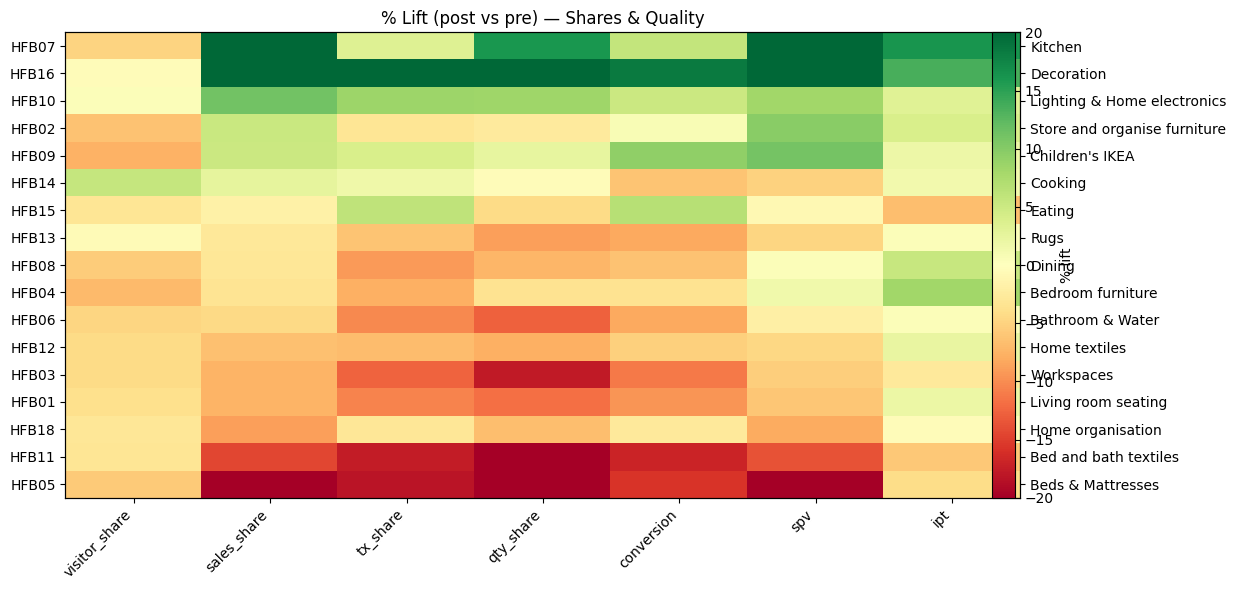

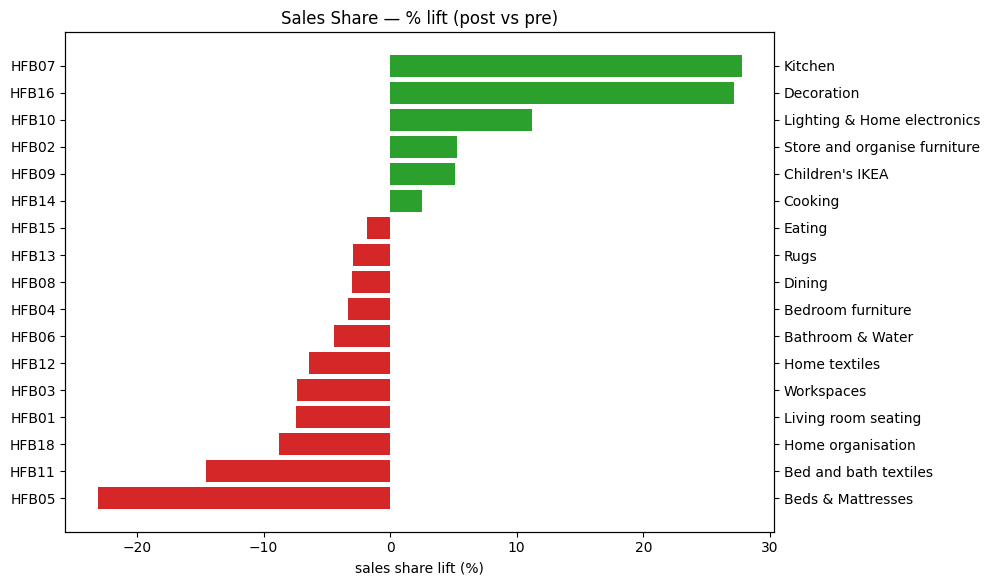

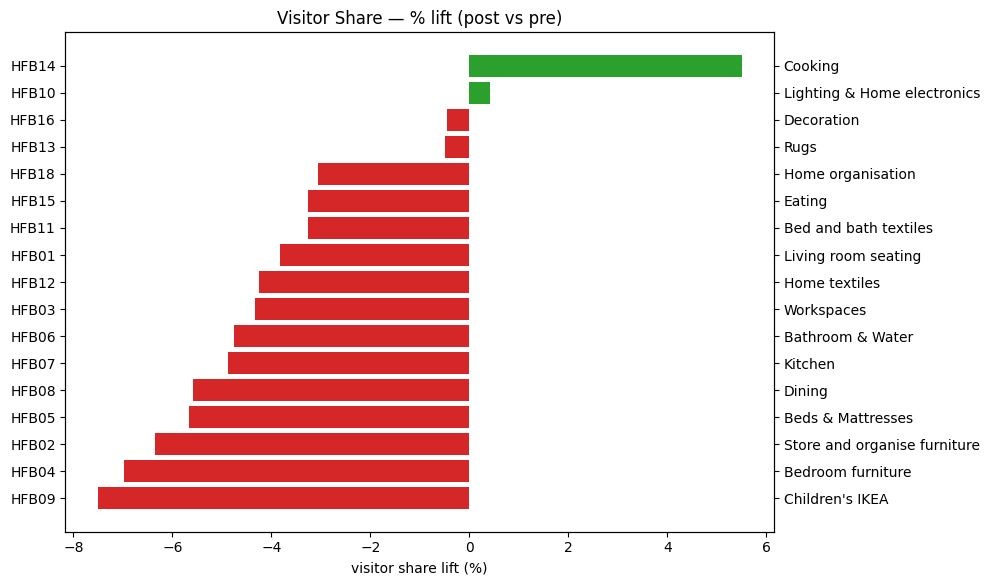

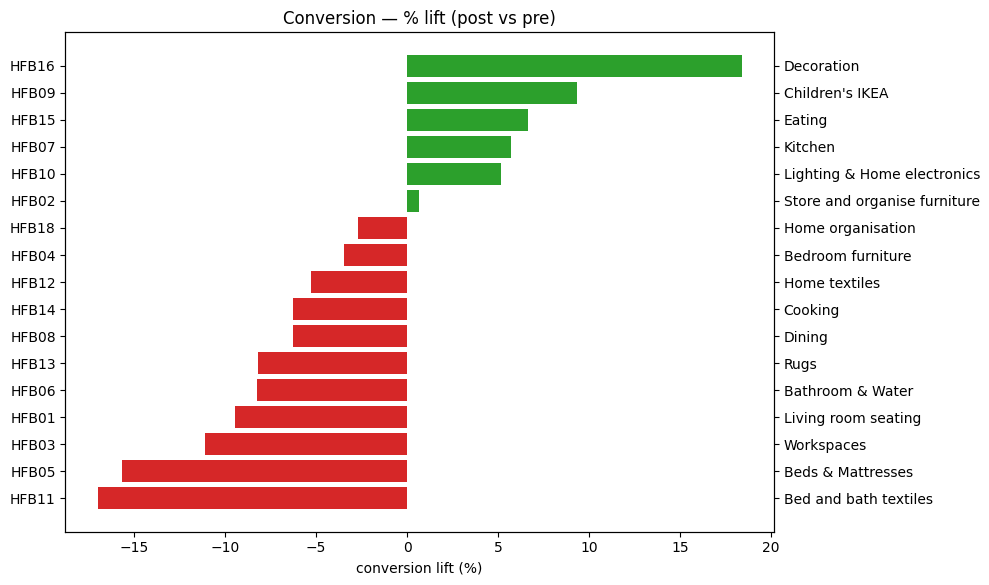

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- inputs ----
DATE1, DATE2 = pd.to_datetime("2025-08-24"), pd.to_datetime("2025-09-14")  # PRE
DATE3, DATE4 = pd.to_datetime("2025-09-28"), pd.to_datetime("2025-10-19")  # POST
LABEL_COL = "name"   # HFB code (e.g., "HFB10")

df = merged_df_hfb.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# ----- helper: aggregate per HFB with store totals joined per-day -----
def build_block(d: pd.DataFrame) -> pd.DataFrame:
    day_tot = (d.groupby("date")
                 .agg(store_visitors=("visitors_daily","max"),
                      store_sales=("created_sales_net_amount_euro","sum"),
                      store_tx=("unique_transaction_identifier","sum"),
                      store_qty=("created_net_quantity","sum"))
                 .reset_index())
    d2 = d.merge(day_tot, on="date", how="left")
    g = d2.groupby(LABEL_COL, as_index=False).agg(
        visitors=("visitors","sum"),
        sales=("created_sales_net_amount_euro","sum"),
        tx=("unique_transaction_identifier","sum"),
        qty=("created_net_quantity","sum"),
        store_visitors=("store_visitors","sum"),
        store_sales=("store_sales","sum"),
        store_tx=("store_tx","sum"),
        store_qty=("store_qty","sum"),
    )
    # shares (area vs store) and per-visitor quality metrics
    g["visitor_share"] = g["visitors"] / g["store_visitors"]
    g["sales_share"]   = g["sales"]    / g["store_sales"]
    g["tx_share"]      = g["tx"]       / g["store_tx"]
    g["qty_share"]     = g["qty"]      / g["store_qty"]
    g["conversion"]    = g["tx"] / g["visitors"].replace(0, np.nan)
    g["spv"]           = g["sales"] / g["visitors"].replace(0, np.nan)   # sales per visitor
    g["ipt"]           = g["qty"] / g["tx"].replace(0, np.nan)           # items per transaction
    return g[[LABEL_COL,"visitor_share","sales_share","tx_share","qty_share","conversion","spv","ipt"]]

pre  = build_block(df[df["date"].between(DATE1, DATE2)])
post = build_block(df[df["date"].between(DATE3, DATE4)])

res = pre.merge(post, on=LABEL_COL, suffixes=("_pre","_post"))

# % lifts (post vs pre)
metrics = ["visitor_share","sales_share","tx_share","qty_share","conversion","spv","ipt"]
for m in metrics:
    res[f"{m}_lift_pct"] = np.where(
        (res[f"{m}_pre"].notna()) & (res[f"{m}_pre"] != 0),
        (res[f"{m}_post"] - res[f"{m}_pre"]) / res[f"{m}_pre"] * 100,
        np.nan
    )

# map code -> full name (for right y-axis labels)
name_to_full = (df[[LABEL_COL,"hfb_name"]].dropna().drop_duplicates()
                  .set_index(LABEL_COL)["hfb_name"])

# -------------------- HEATMAP (share/quality lifts) --------------------
heat_cols = [f"{m}_lift_pct" for m in metrics]
heat = res[[LABEL_COL] + heat_cols].set_index(LABEL_COL)
# order by sales_share lift (optional)
if "sales_share_lift_pct" in heat.columns:
    heat = heat.sort_values("sales_share_lift_pct", ascending=False)

fig, ax = plt.subplots(figsize=(12, max(6, 0.35*len(heat))))
im = ax.imshow(heat.values, aspect="auto", cmap="RdYlGn", vmin=-20, vmax=20)
ax.set_yticks(range(len(heat))); ax.set_yticklabels(heat.index)
ax.set_xticks(range(len(heat_cols))); ax.set_xticklabels([c.replace("_lift_pct","") for c in heat_cols],
                                                         rotation=45, ha="right")
ax.set_title("% Lift (post vs pre) — Shares & Quality")

# right y-axis with hfb_name
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(len(heat)))
ax2.set_yticklabels(name_to_full.reindex(heat.index).fillna("").tolist())
ax2.tick_params(axis="y")

cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02); cbar.set_label("% lift")
plt.tight_layout(); plt.show()

# -------------------- BAR CHARTS (example: sales_share & visitor_share) --------------------
for metric in ["sales_share","visitor_share","conversion"]:
    col = f"{metric}_lift_pct"
    bar = res[[LABEL_COL, col]].dropna().sort_values(col, ascending=False)
    fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(bar))))
    colors = np.where(bar[col] >= 0, "#2ca02c", "#d62728")
    ax.barh(bar[LABEL_COL], bar[col], color=colors)
    ax.invert_yaxis()
    ax.set_xlabel(f"{metric.replace('_',' ')} lift (%)")
    ax.set_title(f"{metric.replace('_',' ').title()} — % lift (post vs pre)")

    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(name_to_full.reindex(bar[LABEL_COL]).fillna("").tolist())
    ax2.tick_params(axis="y")
    plt.tight_layout(); plt.show()


## Try forecast sales in the next section

In [6]:
client = bigquery.Client(project="ingka-pmp-fixa-dev")


/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
## I want to extract the data from the last 3 year to do forecast 

#Code related with the source to be extracted
code=""" 
SELECT
  market_area_no,
  transaction_date,
  cmp_code,
  unique_transaction_identifier,
  icm_customer_no,
  it.item_no,
  it.item_name,
  it.pa_no,
  it.pa_name,
  it.hfb_name,
  it.hfb_no,
  SUM(created_net_quantity) as created_net_quantity,
  SUM( created_sales_net_amount ) AS created_sales_net_amount,
  SUM( delivered_sales_net_amount ) AS delivered_sales_net_amount,
  SUM( created_sales_net_amount_euro ) AS created_sales_net_amount_euro,
  SUM( delivered_sales_net_amount_euro ) AS delivered_sales_net_amount_euro
FROM
  `ingka-sbp-di-prod.common_sales_mart_no_pii.common_sales_bd` AS cs
LEFT JOIN
  `ingka-rrm-erix-prod.erix_legacy_production.item_dim` it
ON
  it.item_no = cs.item_no
WHERE
  transaction_date BETWEEN date'2023-05-01'
  AND date'2025-10-20'
  AND retail_unit_code='SE'
  AND cmp_code = 'STO445'
  AND sales_channel="Store"
  AND source_system in ('SO','CC')
    AND line_type_code = "SALE"
    AND service_flag IS FALSE
  AND  created_sales_net_amount >0
GROUP BY
transaction_date,
  market_area_no,
  cmp_code,
  unique_transaction_identifier,
  icm_customer_no,
  item_no,
  it.item_name,
  it.pa_no,
  it.pa_name,
  it.hfb_name,
  it.hfb_no
ORDER BY
  market_area_no
"""

job=client.query(code)

common_sales_hfb=job.to_dataframe()

E0000 00:00:1761775299.490117 16315725 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [8]:
#### since we are taking the left join with the edx table, there are some entries where item_no is duplicated.. let's remove those
# columns that define duplicates
keys = ['transaction_date', 'unique_transaction_identifier', 'item_no']

# choose the sort order you want BEFORE deduping
# (include a tie-breaker like 'pa_no' if useful)
order = ['transaction_date', 'unique_transaction_identifier', 'item_no', 'pa_no']

# size before
print(f"Before: {common_sales_hfb.shape[0]} rows x {common_sales_hfb.shape[1]} cols")

# sort, then keep the first row of each key group
df_sorted = common_sales_hfb.sort_values(order, kind='mergesort')  # stable sort
df_keep_first = df_sorted.drop_duplicates(subset=keys, keep='first')

# size after
print(f"After : {df_keep_first.shape[0]} rows x {df_keep_first.shape[1]} cols")
print(f"Removed {common_sales_hfb.shape[0] - df_keep_first.shape[0]} duplicate rows")
common_sales_hfb=df_keep_first


Before: 21875998 rows x 16 cols
After : 21813602 rows x 16 cols
Removed 62396 duplicate rows


## HFB10

In [9]:
#remove food and services
#grouped_cs_no_food=common_sales_hfb.loc[(common_sales_hfb.hfb_no!='61') & (common_sales_hfb.hfb_no!='60') 
 #   & (common_sales_hfb.hfb_no!='95') ].groupby(['market_area_no','transaction_date']).agg({
#    'created_net_quantity' : ['sum'],
 #   'created_sales_net_amount_euro' : ['sum'],
  #  'unique_transaction_identifier' : ['nunique']
    
  #      }).reset_index()

#remove food and services
grouped_cs_no_food=common_sales_hfb.loc[(common_sales_hfb.hfb_no=='10')  ].groupby(['market_area_no','transaction_date']).agg({
    'created_net_quantity' : ['sum'],
    'created_sales_net_amount_euro' : ['sum'],
    'unique_transaction_identifier' : ['nunique']
    
        }).reset_index()
grouped_cs_no_food.columns = grouped_cs_no_food.columns.map('_'.join)
grouped_cs_no_food.rename(columns = {                               
                                    'market_area_no_' : 'market_area_no',
                                    'transaction_date_' : 'transaction_date',
                                    'created_net_quantity_sum' : 'created_net_quantity',
                                    'created_sales_net_amount_euro_sum' : 'created_sales_net_amount_euro',
                                    'unique_transaction_identifier_nunique' : 'unique_transaction_identifier'
                         }, inplace = True)

grouped_cs_no_food['transaction_date'] = pd.to_datetime(grouped_cs_no_food['transaction_date'])
grouped_cs_no_food.head()


,market_area_no,transaction_date,created_net_quantity,created_sales_net_amount_euro,unique_transaction_identifier
0,445,2023-05-01,1517.000000000,16503.886156800,546
1,445,2023-05-02,1227.000000000,12472.729382400,349
2,445,2023-05-03,1047.000000000,11091.579744000,335
3,445,2023-05-04,1042.000000000,10155.957548800,330
4,445,2023-05-05,1432.000000000,16429.170374400,442


In [29]:
grouped_cs_no_food.loc[grouped_cs_no_food.created_sales_net_amount_euro>60000]

,market_area_no,transaction_date,created_net_quantity,created_sales_net_amount_euro,unique_transaction_identifier
593,445,2024-12-22,3247.000000000,92524.864432000,1047


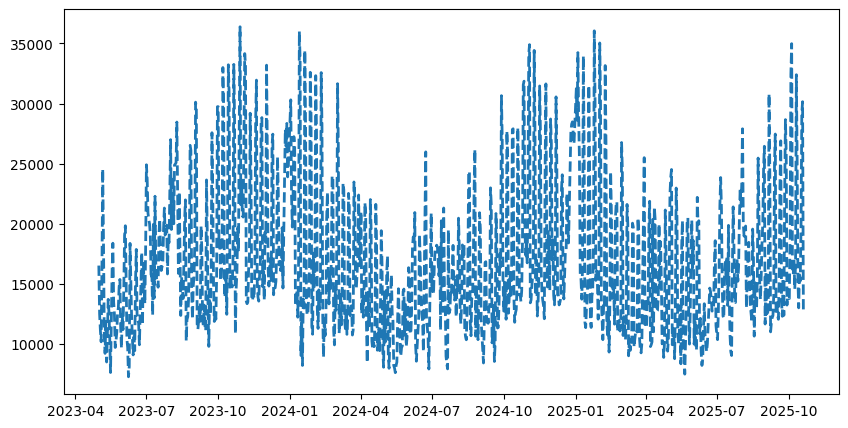

In [30]:


# Inputs
target_names = ["HFB14","HFB10"]
target_store = "445"

# Prep
df = grouped_cs_no_food.loc[grouped_cs_no_food.created_sales_net_amount_euro<60000].copy()#loc[grouped_cs_no_food.name=="HFB10"].copy()
df["date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
df["store_str"] = df["market_area_no"].astype(str)

fig, ax = plt.subplots(figsize=(10, 5))


# Plot store_total on the SAME y-axis (no sum; one value per day)

ax.plot(df.transaction_date, df.created_sales_net_amount_euro, linestyle="--", linewidth=2.0, label="Store total")



/tmp/ipykernel_93721/3225032100.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return x.mask(z.abs() > thresh).interpolate("time").fillna(method="bfill").fillna(method="ffill")


Estimated sales lift (post vs expected): 8.85% [95% CI: -8.09% , 25.80%], p≈0.306
(Absolute effect: 37,207 vs expected 420,266)


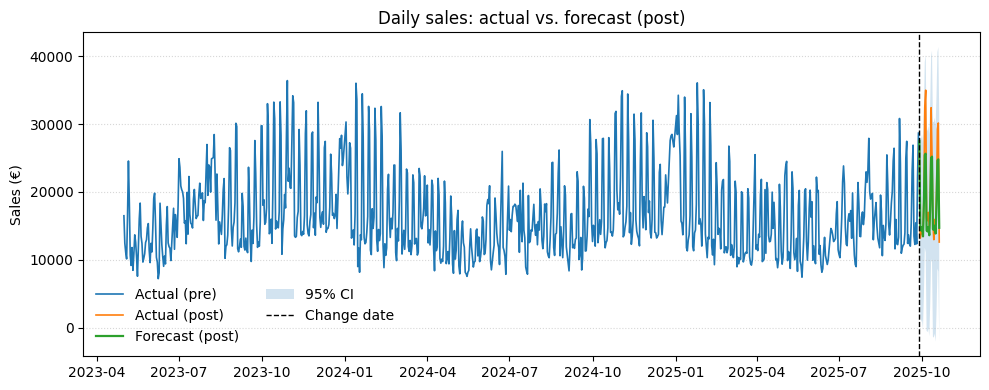

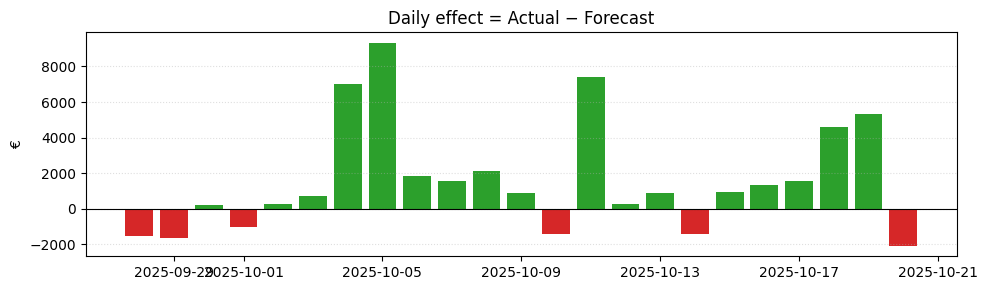

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import erf, sqrt

# -----------------------------
# 1) Load & basic prep
# -----------------------------
CHANGE_DATE = "2025-09-28"  # intervention date (first day AFTER pre period)
DATE_COL = "transaction_date"
Y_COL    = "created_sales_net_amount_euro"

df = grouped_cs_no_food.loc[grouped_cs_no_food.created_sales_net_amount_euro<60000].copy()

# Make sure numeric columns are float64 (not Decimal or object)
NUM_COLS = ["created_sales_net_amount_euro",
            "created_net_quantity",
            "unique_transaction_identifier"]

for c in NUM_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")


df[DATE_COL] = pd.to_datetime(df[DATE_COL])
s = (df
     .set_index(DATE_COL)
     .sort_index()[Y_COL]
     .asfreq("D"))  # daily frequency; fill later

# fill small gaps to keep model simple (time interpolation, then 0 at ends)
s = s.interpolate(method="time").fillna(0)

# -----------------------------
# 2) Robust outlier smoothing (MAD) on PRE only
# -----------------------------
change_ts = pd.to_datetime(CHANGE_DATE)
pre = s.loc[:change_ts - pd.Timedelta(days=1)].copy()

def mad_smooth(x, thresh=5):
    med = x.median()
    mad = np.median(np.abs(x - med))
    if mad == 0: 
        return x
    z = 0.6745 * (x - med) / mad
    return x.mask(z.abs() > thresh).interpolate("time").fillna(method="bfill").fillna(method="ffill")

pre_clean = mad_smooth(pre)

# keep post untouched (we want to measure the impact there)
post = s.loc[change_ts:].copy()
if post.empty:
    raise ValueError("No post-change data after CHANGE_DATE.")

# -----------------------------
# 3) Fit SARIMAX on PRE (trend + weekly seasonality)
# -----------------------------
model = SARIMAX(pre_clean,
                order=(1,1,1),
                seasonal_order=(1,0,1,7),
                trend="t",
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

# -----------------------------
# 4) Forecast POST & compute lift
# -----------------------------
steps = len(post)
pred = res.get_forecast(steps=steps)
f_mean = pred.predicted_mean
f_ci   = pred.conf_int(alpha=0.05)
se     = pred.se_mean  # std error per-forecast

# Align to post index
f_mean.index = post.index
f_ci.index   = post.index
se.index     = post.index

effect = post - f_mean                          # actual - forecast
total_effect = effect.sum()                     # € lift over window
total_pred   = f_mean.sum()
lift_pct     = (total_effect / total_pred) * 100  # % lift vs. expected

# 95% CI for total effect (sum of daily errors; assumes independence)
se_total = float(np.sqrt(np.sum(se**2)))
ci_eff_low  = total_effect - 1.96 * se_total
ci_eff_high = total_effect + 1.96 * se_total
# convert to % lift CI using delta method
ci_lift_low  = (ci_eff_low  / total_pred) * 100
ci_lift_high = (ci_eff_high / total_pred) * 100

# (optional) p-value for total effect (normal approx)
z = total_effect / se_total if se_total > 0 else np.nan
def norm_cdf(x): return 0.5 * (1 + erf(x / sqrt(2)))
p_two_sided = 2 * (1 - norm_cdf(abs(z))) if np.isfinite(z) else np.nan

print(f"Estimated sales lift (post vs expected): {lift_pct:,.2f}% "
      f"[95% CI: {ci_lift_low:,.2f}% , {ci_lift_high:,.2f}%], p≈{p_two_sided:,.3f}")
print(f"(Absolute effect: {total_effect:,.0f} vs expected {total_pred:,.0f})")

# -----------------------------
# 5) Plot: actual vs forecast (with bands) and daily effect
# -----------------------------
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pre.index, pre, label="Actual (pre)", linewidth=1.2)
ax.plot(post.index, post, label="Actual (post)", linewidth=1.2)
ax.plot(f_mean.index, f_mean, label="Forecast (post)", linewidth=1.6)
ax.fill_between(f_ci.index, f_ci.iloc[:,0], f_ci.iloc[:,1], alpha=0.20, label="95% CI")
ax.axvline(change_ts, color="k", linestyle="--", linewidth=1, label="Change date")
ax.set_title("Daily sales: actual vs. forecast (post)")
ax.set_ylabel("Sales (€)"); ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10,3))
ax.bar(effect.index, effect, width=0.8, color=np.where(effect>=0,"#2ca02c","#d62728"))
ax.axhline(0, color="k", linewidth=0.8)
ax.set_title("Daily effect = Actual − Forecast")
ax.set_ylabel("€"); ax.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout(); plt.show()


In [60]:
DATE1, DATE2 = pd.to_datetime("2025-08-24"), pd.to_datetime("2025-09-14")  # PRE window
DATE3, DATE4 = pd.to_datetime("2025-09-28"), pd.to_datetime("2025-10-19")  # POST window

#2024-08-25 - 2024-09-15
#2024-09-29 - 2024-10-20

display(grouped_cs_no_food.loc[(grouped_cs_no_food.transaction_date>="2025-08-24") &
    (grouped_cs_no_food.transaction_date<="2025-09-14")].created_sales_net_amount_euro.sum())


display(grouped_cs_no_food.loc[(grouped_cs_no_food.transaction_date>="2025-09-28") &
    (grouped_cs_no_food.transaction_date<="2025-10-19")].created_sales_net_amount_euro.sum())


display(grouped_cs_no_food.loc[(grouped_cs_no_food.transaction_date>="2024-08-25") &
    (grouped_cs_no_food.transaction_date<="2024-09-15")].created_sales_net_amount_euro.sum())


display(grouped_cs_no_food.loc[(grouped_cs_no_food.transaction_date>="2024-09-29") &
    (grouped_cs_no_food.transaction_date<="2024-10-20")].created_sales_net_amount_euro.sum())

Decimal('389502.122352280')

Decimal('444838.243813880')

Decimal('321519.825846800')

Decimal('394690.919524160')

In [61]:
(394690.919524160-321519.825846800)/321519.825846800

0.22757879233308945

In [62]:
(444838.243813880-389502.122352280)/389502.122352280


0.14206885735927258

In [63]:
(0.22757879233308945-0.14206885735927258)/0.14206885735927258

0.6018907772135734

In [16]:
(444838.243813880-394690.919524160)/394690.919524160

0.12705466938580126

### HFB14

In [33]:
#remove food and services
#grouped_cs_no_food=common_sales_hfb.loc[(common_sales_hfb.hfb_no!='61') & (common_sales_hfb.hfb_no!='60') 
 #   & (common_sales_hfb.hfb_no!='95') ].groupby(['market_area_no','transaction_date']).agg({
#    'created_net_quantity' : ['sum'],
 #   'created_sales_net_amount_euro' : ['sum'],
  #  'unique_transaction_identifier' : ['nunique']
    
  #      }).reset_index()

#remove food and services
grouped_cs_no_food_14=common_sales_hfb.loc[(common_sales_hfb.hfb_no=='14')  ].groupby(['market_area_no','transaction_date']).agg({
    'created_net_quantity' : ['sum'],
    'created_sales_net_amount_euro' : ['sum'],
    'unique_transaction_identifier' : ['nunique']
    
        }).reset_index()
grouped_cs_no_food_14.columns = grouped_cs_no_food_14.columns.map('_'.join)
grouped_cs_no_food_14.rename(columns = {                               
                                    'market_area_no_' : 'market_area_no',
                                    'transaction_date_' : 'transaction_date',
                                    'created_net_quantity_sum' : 'created_net_quantity',
                                    'created_sales_net_amount_euro_sum' : 'created_sales_net_amount_euro',
                                    'unique_transaction_identifier_nunique' : 'unique_transaction_identifier'
                         }, inplace = True)

grouped_cs_no_food_14['transaction_date'] = pd.to_datetime(grouped_cs_no_food_14['transaction_date'])
grouped_cs_no_food_14.head()


,market_area_no,transaction_date,created_net_quantity,created_sales_net_amount_euro,unique_transaction_identifier
0,445,2023-05-01,4109.000000000,15858.898160000,1111
1,445,2023-05-02,2674.000000000,10168.628646400,724
2,445,2023-05-03,2385.000000000,9625.956121600,684
3,445,2023-05-04,2644.000000000,10527.570256000,680
4,445,2023-05-05,2849.000000000,10274.002659200,843


/tmp/ipykernel_93721/4100049282.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return x.mask(z.abs() > thresh).interpolate("time").fillna(method="bfill").fillna(method="ffill")


Estimated sales lift (post vs expected): 5.15% [95% CI: -13.33% , 23.63%], p≈0.585
(Absolute effect: 17,539 vs expected 340,694)


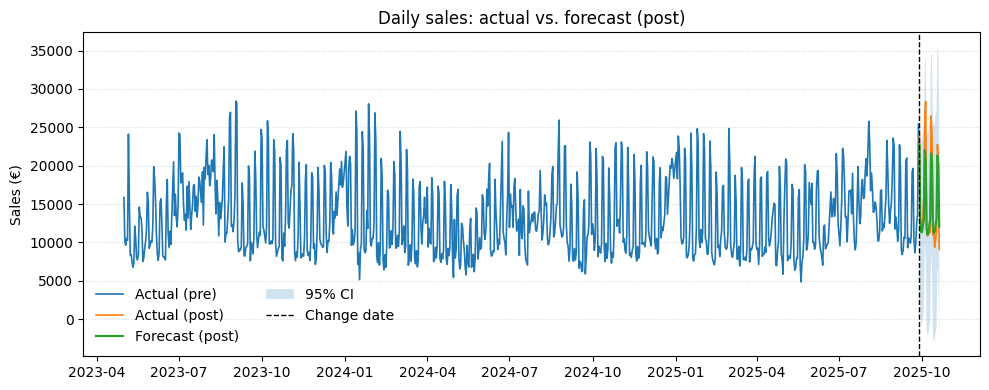

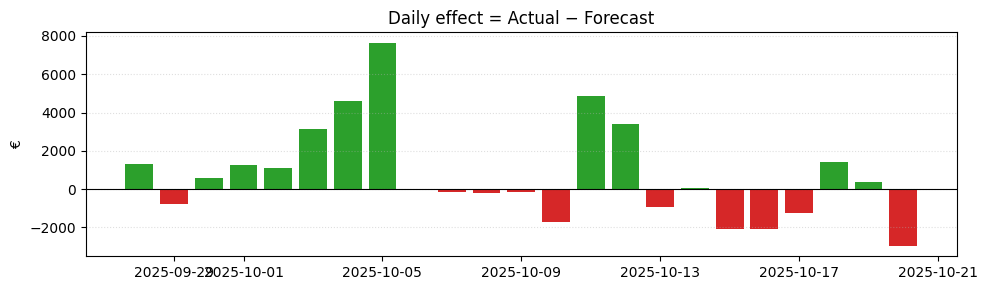

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import erf, sqrt

# -----------------------------
# 1) Load & basic prep
# -----------------------------
CHANGE_DATE = "2025-09-28"  # intervention date (first day AFTER pre period)
DATE_COL = "transaction_date"
Y_COL    = "created_sales_net_amount_euro"

df = grouped_cs_no_food_14.copy()

# Make sure numeric columns are float64 (not Decimal or object)
NUM_COLS = ["created_sales_net_amount_euro",
            "created_net_quantity",
            "unique_transaction_identifier"]

for c in NUM_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")


df[DATE_COL] = pd.to_datetime(df[DATE_COL])
s = (df
     .set_index(DATE_COL)
     .sort_index()[Y_COL]
     .asfreq("D"))  # daily frequency; fill later

# fill small gaps to keep model simple (time interpolation, then 0 at ends)
s = s.interpolate(method="time").fillna(0)

# -----------------------------
# 2) Robust outlier smoothing (MAD) on PRE only
# -----------------------------
change_ts = pd.to_datetime(CHANGE_DATE)
pre = s.loc[:change_ts - pd.Timedelta(days=1)].copy()

def mad_smooth(x, thresh=5):
    med = x.median()
    mad = np.median(np.abs(x - med))
    if mad == 0: 
        return x
    z = 0.6745 * (x - med) / mad
    return x.mask(z.abs() > thresh).interpolate("time").fillna(method="bfill").fillna(method="ffill")

pre_clean = mad_smooth(pre)

# keep post untouched (we want to measure the impact there)
post = s.loc[change_ts:].copy()
if post.empty:
    raise ValueError("No post-change data after CHANGE_DATE.")

# -----------------------------
# 3) Fit SARIMAX on PRE (trend + weekly seasonality)
# -----------------------------
model = SARIMAX(pre_clean,
                order=(1,1,1),
                seasonal_order=(1,0,1,7),
                trend="t",
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

# -----------------------------
# 4) Forecast POST & compute lift
# -----------------------------
steps = len(post)
pred = res.get_forecast(steps=steps)
f_mean = pred.predicted_mean
f_ci   = pred.conf_int(alpha=0.05)
se     = pred.se_mean  # std error per-forecast

# Align to post index
f_mean.index = post.index
f_ci.index   = post.index
se.index     = post.index

effect = post - f_mean                          # actual - forecast
total_effect = effect.sum()                     # € lift over window
total_pred   = f_mean.sum()
lift_pct     = (total_effect / total_pred) * 100  # % lift vs. expected

# 95% CI for total effect (sum of daily errors; assumes independence)
se_total = float(np.sqrt(np.sum(se**2)))
ci_eff_low  = total_effect - 1.96 * se_total
ci_eff_high = total_effect + 1.96 * se_total
# convert to % lift CI using delta method
ci_lift_low  = (ci_eff_low  / total_pred) * 100
ci_lift_high = (ci_eff_high / total_pred) * 100

# (optional) p-value for total effect (normal approx)
z = total_effect / se_total if se_total > 0 else np.nan
def norm_cdf(x): return 0.5 * (1 + erf(x / sqrt(2)))
p_two_sided = 2 * (1 - norm_cdf(abs(z))) if np.isfinite(z) else np.nan

print(f"Estimated sales lift (post vs expected): {lift_pct:,.2f}% "
      f"[95% CI: {ci_lift_low:,.2f}% , {ci_lift_high:,.2f}%], p≈{p_two_sided:,.3f}")
print(f"(Absolute effect: {total_effect:,.0f} vs expected {total_pred:,.0f})")

# -----------------------------
# 5) Plot: actual vs forecast (with bands) and daily effect
# -----------------------------
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pre.index, pre, label="Actual (pre)", linewidth=1.2)
ax.plot(post.index, post, label="Actual (post)", linewidth=1.2)
ax.plot(f_mean.index, f_mean, label="Forecast (post)", linewidth=1.6)
ax.fill_between(f_ci.index, f_ci.iloc[:,0], f_ci.iloc[:,1], alpha=0.20, label="95% CI")
ax.axvline(change_ts, color="k", linestyle="--", linewidth=1, label="Change date")
ax.set_title("Daily sales: actual vs. forecast (post)")
ax.set_ylabel("Sales (€)"); ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10,3))
ax.bar(effect.index, effect, width=0.8, color=np.where(effect>=0,"#2ca02c","#d62728"))
ax.axhline(0, color="k", linewidth=0.8)
ax.set_title("Daily effect = Actual − Forecast")
ax.set_ylabel("€"); ax.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout(); plt.show()


### HFB 16

In [35]:
#remove food and services
#grouped_cs_no_food=common_sales_hfb.loc[(common_sales_hfb.hfb_no!='61') & (common_sales_hfb.hfb_no!='60') 
 #   & (common_sales_hfb.hfb_no!='95') ].groupby(['market_area_no','transaction_date']).agg({
#    'created_net_quantity' : ['sum'],
 #   'created_sales_net_amount_euro' : ['sum'],
  #  'unique_transaction_identifier' : ['nunique']
    
  #      }).reset_index()

#remove food and services
grouped_cs_no_food_16=common_sales_hfb.loc[(common_sales_hfb.hfb_no=='16')  ].groupby(['market_area_no','transaction_date']).agg({
    'created_net_quantity' : ['sum'],
    'created_sales_net_amount_euro' : ['sum'],
    'unique_transaction_identifier' : ['nunique']
    
        }).reset_index()
grouped_cs_no_food_16.columns = grouped_cs_no_food_16.columns.map('_'.join)
grouped_cs_no_food_16.rename(columns = {                               
                                    'market_area_no_' : 'market_area_no',
                                    'transaction_date_' : 'transaction_date',
                                    'created_net_quantity_sum' : 'created_net_quantity',
                                    'created_sales_net_amount_euro_sum' : 'created_sales_net_amount_euro',
                                    'unique_transaction_identifier_nunique' : 'unique_transaction_identifier'
                         }, inplace = True)

grouped_cs_no_food_16['transaction_date'] = pd.to_datetime(grouped_cs_no_food_16['transaction_date'])
grouped_cs_no_food_16.head()


,market_area_no,transaction_date,created_net_quantity,created_sales_net_amount_euro,unique_transaction_identifier
0,445,2023-05-01,3475.000000000,22300.185084800,1108
1,445,2023-05-02,2151.000000000,11881.193027200,659
2,445,2023-05-03,2266.000000000,12943.016441600,637
3,445,2023-05-04,2658.000000000,14745.589308800,719
4,445,2023-05-05,2847.000000000,17244.489964800,843


/tmp/ipykernel_93721/2824039392.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return x.mask(z.abs() > thresh).interpolate("time").fillna(method="bfill").fillna(method="ffill")


Estimated sales lift (post vs expected): 4.92% [95% CI: -12.55% , 22.40%], p≈0.581
(Absolute effect: 24,708 vs expected 501,799)


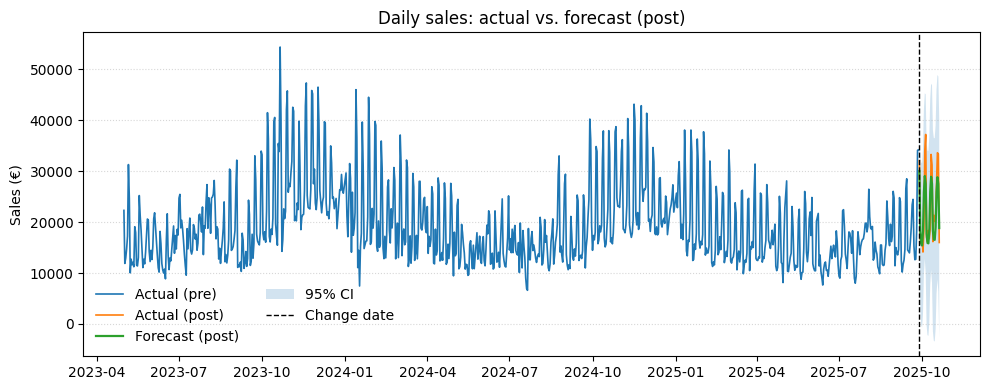

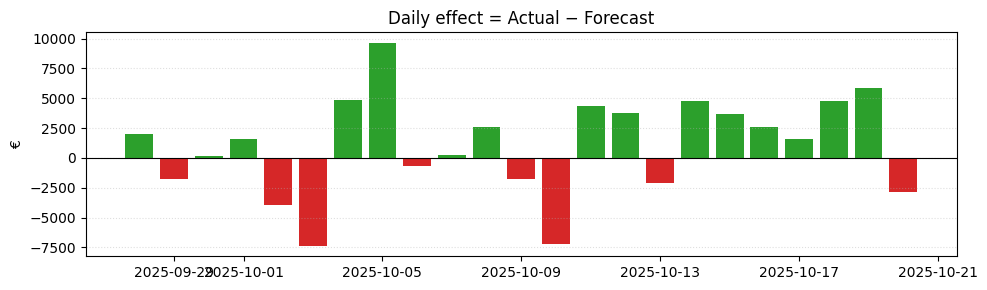

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import erf, sqrt

# -----------------------------
# 1) Load & basic prep
# -----------------------------
CHANGE_DATE = "2025-09-28"  # intervention date (first day AFTER pre period)
DATE_COL = "transaction_date"
Y_COL    = "created_sales_net_amount_euro"

df = grouped_cs_no_food_16.copy()

# Make sure numeric columns are float64 (not Decimal or object)
NUM_COLS = ["created_sales_net_amount_euro",
            "created_net_quantity",
            "unique_transaction_identifier"]

for c in NUM_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")


df[DATE_COL] = pd.to_datetime(df[DATE_COL])
s = (df
     .set_index(DATE_COL)
     .sort_index()[Y_COL]
     .asfreq("D"))  # daily frequency; fill later

# fill small gaps to keep model simple (time interpolation, then 0 at ends)
s = s.interpolate(method="time").fillna(0)

# -----------------------------
# 2) Robust outlier smoothing (MAD) on PRE only
# -----------------------------
change_ts = pd.to_datetime(CHANGE_DATE)
pre = s.loc[:change_ts - pd.Timedelta(days=1)].copy()

def mad_smooth(x, thresh=5):
    med = x.median()
    mad = np.median(np.abs(x - med))
    if mad == 0: 
        return x
    z = 0.6745 * (x - med) / mad
    return x.mask(z.abs() > thresh).interpolate("time").fillna(method="bfill").fillna(method="ffill")

pre_clean = mad_smooth(pre)

# keep post untouched (we want to measure the impact there)
post = s.loc[change_ts:].copy()
if post.empty:
    raise ValueError("No post-change data after CHANGE_DATE.")

# -----------------------------
# 3) Fit SARIMAX on PRE (trend + weekly seasonality)
# -----------------------------
model = SARIMAX(pre_clean,
                order=(1,1,1),
                seasonal_order=(1,0,1,7),
                trend="t",
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

# -----------------------------
# 4) Forecast POST & compute lift
# -----------------------------
steps = len(post)
pred = res.get_forecast(steps=steps)
f_mean = pred.predicted_mean
f_ci   = pred.conf_int(alpha=0.05)
se     = pred.se_mean  # std error per-forecast

# Align to post index
f_mean.index = post.index
f_ci.index   = post.index
se.index     = post.index

effect = post - f_mean                          # actual - forecast
total_effect = effect.sum()                     # € lift over window
total_pred   = f_mean.sum()
lift_pct     = (total_effect / total_pred) * 100  # % lift vs. expected

# 95% CI for total effect (sum of daily errors; assumes independence)
se_total = float(np.sqrt(np.sum(se**2)))
ci_eff_low  = total_effect - 1.96 * se_total
ci_eff_high = total_effect + 1.96 * se_total
# convert to % lift CI using delta method
ci_lift_low  = (ci_eff_low  / total_pred) * 100
ci_lift_high = (ci_eff_high / total_pred) * 100

# (optional) p-value for total effect (normal approx)
z = total_effect / se_total if se_total > 0 else np.nan
def norm_cdf(x): return 0.5 * (1 + erf(x / sqrt(2)))
p_two_sided = 2 * (1 - norm_cdf(abs(z))) if np.isfinite(z) else np.nan

print(f"Estimated sales lift (post vs expected): {lift_pct:,.2f}% "
      f"[95% CI: {ci_lift_low:,.2f}% , {ci_lift_high:,.2f}%], p≈{p_two_sided:,.3f}")
print(f"(Absolute effect: {total_effect:,.0f} vs expected {total_pred:,.0f})")

# -----------------------------
# 5) Plot: actual vs forecast (with bands) and daily effect
# -----------------------------
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pre.index, pre, label="Actual (pre)", linewidth=1.2)
ax.plot(post.index, post, label="Actual (post)", linewidth=1.2)
ax.plot(f_mean.index, f_mean, label="Forecast (post)", linewidth=1.6)
ax.fill_between(f_ci.index, f_ci.iloc[:,0], f_ci.iloc[:,1], alpha=0.20, label="95% CI")
ax.axvline(change_ts, color="k", linestyle="--", linewidth=1, label="Change date")
ax.set_title("Daily sales: actual vs. forecast (post)")
ax.set_ylabel("Sales (€)"); ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10,3))
ax.bar(effect.index, effect, width=0.8, color=np.where(effect>=0,"#2ca02c","#d62728"))
ax.axhline(0, color="k", linewidth=0.8)
ax.set_title("Daily effect = Actual − Forecast")
ax.set_ylabel("€"); ax.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout(); plt.show()
